# Setup

---



Install python packages.

In [0]:
!pip install scanpy
!pip install python-igraph
!pip install louvain
!pip install seaborn
!pip install scipy
!pip install sklearn
!pip install rpy2==3.2.2
!pip install anndata2ri
!pip install diffxpy
!pip install bbknn
!pip install loompy

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import csv
import scanpy as sc
import seaborn as sb
import scipy as sp
import matplotlib.pyplot as plt
import diffxpy.api as de
import bbknn as bk
from rpy2.robjects import pandas2ri
import anndata2ri
from rpy2.robjects import r
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython
import base64
import json
import os
import zlib
#from optparse import OptionParser
import loompy as lp

In [0]:
%%R
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("S4Vectors")
BiocManager::install("SingleCellExperiment")
BiocManager::install('RColorBrewer')
BiocManager::install('slingshot')
BiocManager::install('scater')

In [5]:
%%R
library(RColorBrewer)
library(slingshot)
library(scater)

R[write to console]: Loading required package: princurve

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
 

In [6]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '/content/drive/My Drive/IntegratedProject/Data/write/facs_Tcell.h5ad'  # the file that will store the analysis results

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.4 scipy==1.3.3 pandas==0.25.3 scikit-learn==0.21.3 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [0]:
sc.settings.set_figure_params(dpi=80)

# Data selection

---



In [0]:
meta = pd.read_csv("/content/drive/My Drive/IntegratedProject/Data/Metadata/TM_facs_metadata.csv") #need to switch to metadata for entire set of data
adata = sc.read_csv(
    '/content/drive/My Drive/IntegratedProject/Data/TM_facs_mat_Tcell.csv') #file needs to be switched to one containing all the data

In [0]:
adata.var_names_make_unique()  # this is unnecessary if using 'gene_ids'

Adding new columns to adata.obs to keep track of plate, id of the mouse, sex of the mouse, tissue, subtiusse and the cell annotation from the original paper.

Then each of these columns is filled with the respective data from the metadata for each cell.

In [0]:
adata.obs = adata.obs.assign(plate='')
adata.obs = adata.obs.assign(mouse_id='')
adata.obs = adata.obs.assign(mouse_sex='')
adata.obs = adata.obs.assign(tissue='')
adata.obs = adata.obs.assign(subtissue='')
adata.obs = adata.obs.assign(ref_annotation='')

for i in range(len(meta)):
  cellid = meta.iloc[i,0]
  if cellid in adata.obs_names:
    if meta.iloc[i,7] == 'NA':
      cells_na.append(cellid)
    adata.obs.loc[cellid, 'plate'] = meta.iloc[i,1]
    adata.obs.loc[cellid, 'mouse_id'] = meta.iloc[i,2]
    adata.obs.loc[cellid, 'mouse_sex'] = meta.iloc[i,6]
    adata.obs.loc[cellid, 'tissue'] = meta.iloc[i,3]
    adata.obs.loc[cellid, 'subtissue'] = meta.iloc[i,4]
    adata.obs.loc[cellid, 'ref_annotation'] = meta.iloc[i,7]

In [11]:
adata

AnnData object with n_obs × n_vars = 2226 × 23433 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation'

# Preprocessing

First we remove the spike in ERCC genes.

In [12]:
adata = adata[:,adata.var_names.str.startswith('ERCC')!=True]
adata

View of AnnData object with n_obs × n_vars = 2226 × 23341 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation'

Each cell and gene are individually shown to see how many genes are expressed in each cell as well as how many cells each gene is expressed in.

In [13]:
sc.pp.calculate_qc_metrics(adata)

(                         n_genes_by_counts  ...  pct_counts_in_top_500_genes
 A1.B000827.3_38_F.1.1                 4193  ...                    63.632780
 A1.B003291.3_39_F.1.1                 3349  ...                    64.602760
 A1.MAA000607.3_9_M.1.1                1900  ...                    82.861362
 A1.MAA000880.3_11_M.1.1               4243  ...                    56.603067
 A1.MAA001888.3_39_F.1.1               2486  ...                    78.710060
 ...                                    ...  ...                          ...
 P9.MAA000556.3_9_M.1.1                1424  ...                    92.876862
 P9.MAA000607.3_9_M.1.1                2452  ...                    74.049917
 P9.MAA000609.3_8_M.1.1                1756  ...                    86.238122
 P9.MAA000880.3_11_M.1.1               1666  ...                    79.658392
 P9.MAA001888.3_39_F.1.1               1960  ...                    83.483353
 
 [2226 rows x 8 columns],
                    n_cells_by_count

Basic filtering on our data so that genes that are detected in less than 3 cells are removed as well as cells that have less than 500 genes expressed and cells that have less than 50,000 counts.

In [14]:
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.filter_cells(adata, min_counts=50000)
sc.pp.filter_genes(adata, min_cells=3)
adata

Trying to set attribute `.obs` of view, making a copy.


filtered out 6871 genes that are detectedin less than 3 cells


AnnData object with n_obs × n_vars = 2226 × 16470 
    obs: 'plate', 'mouse_id', 'mouse_sex', 'tissue', 'subtissue', 'ref_annotation', 'n_genes', 'n_counts'
    var: 'n_cells'

Computes for each gene the fraction of counts assigned to that gene within a cell and shows a boxplot with the top 20 genes with the highest mean fraction across all cells.

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


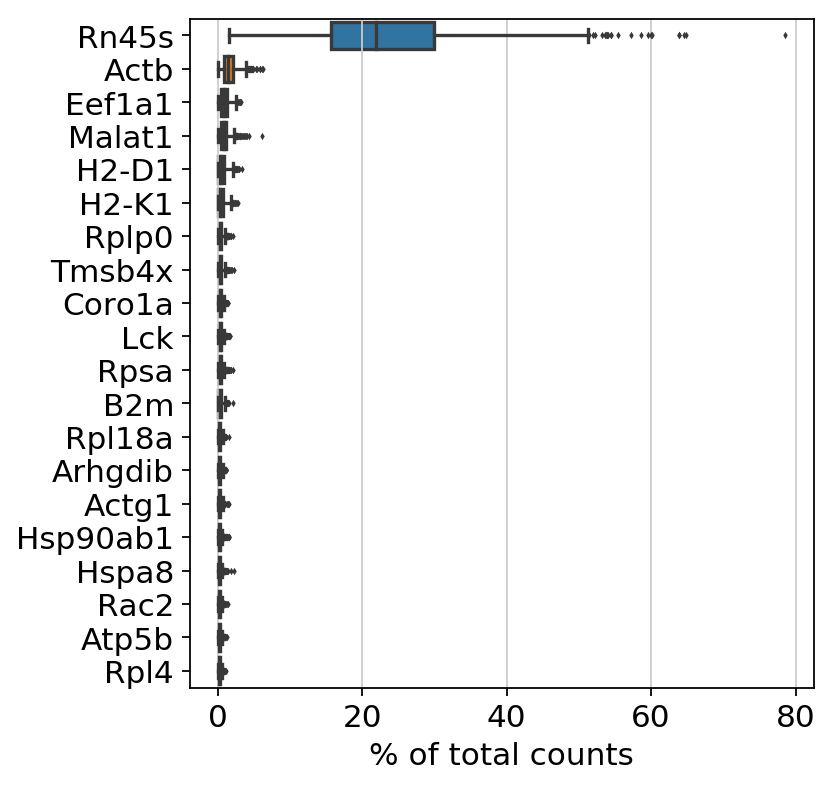

In [15]:
sc.pl.highest_expr_genes(adata, n_top=20)

Collect a list of the mitochondrial genes in our data set and create a new observation column in the adata.obs percent_mito which is the percentage of mitochondrial gene counts vs all total gene counts.

Having information about mitochonrdrial genes is important because high proportions are indicative of poor-quality cells since this could indicate a cell with tears in the cell membrane and since mitochondria are larger than individual transcript molecules they are less likely to escape through the tears.

The n_counts observation is also updated to account for the filtering done previously.

In [0]:
mito_genes = adata.var_names.str.startswith('mt-','tssr')

adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1) / np.sum(adata.X, axis=1)

adata.obs['n_counts'] = adata.X.sum(axis=1)

Create a violin plot for the number of genes and counts for each cell to provide more information about our cells for future filtering.

... storing 'plate' as categorical
... storing 'mouse_id' as categorical
... storing 'mouse_sex' as categorical
... storing 'tissue' as categorical
... storing 'subtissue' as categorical
... storing 'ref_annotation' as categorical


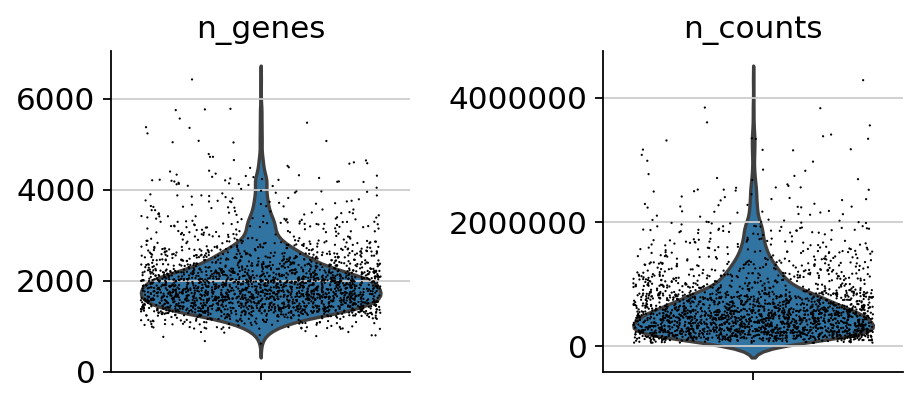

In [17]:
sc.pl.violin(adata, ['n_genes', 'n_counts'],
             jitter=0.4, multi_panel=True)


Create two scatter plots, the first comparing the number of counts and percentage of mitochonridal genes and the second comparing number of counts and number of genes for our dataset.

The first scatter plot is commented out because we do not actually have any mitochondrial genes in our data.



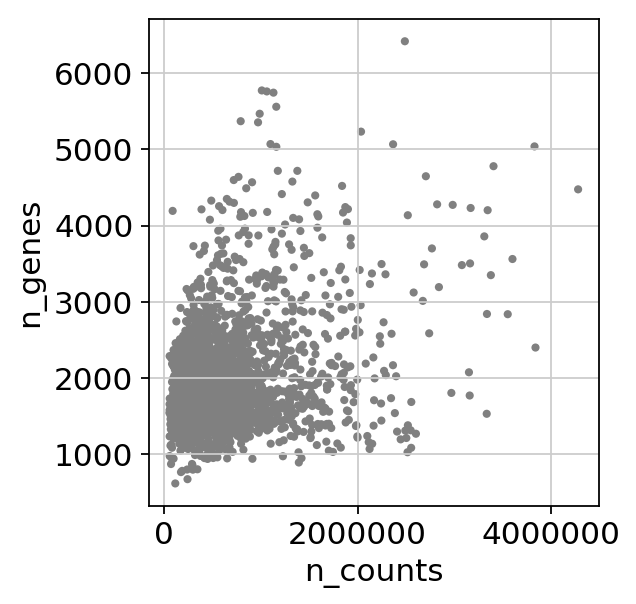

In [18]:
#sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

Check our data to see how the number of counts and number of genes are distributed across our cells.

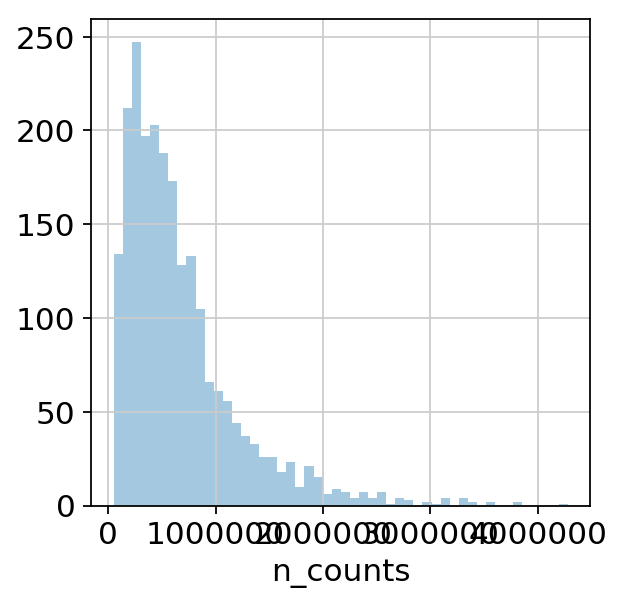

In [19]:
sb.distplot(adata.obs['n_counts'], kde=False)

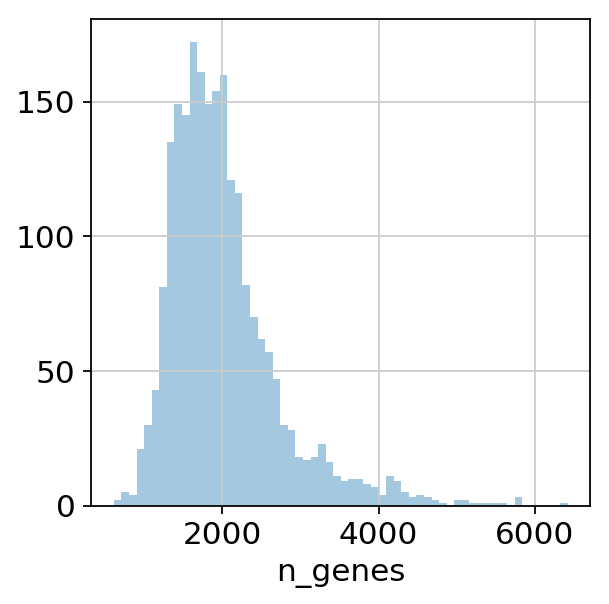

In [20]:
sb.distplot(adata.obs['n_genes'], kde=False, bins=60)

Based on the previous plots we filter our data again to remove cells with too low or too high number of genes and cells with too low and too high number of counts. If there were mitochondrial genes present then cells with too high a percentage of those genes would be removed also.

These cells are filtered out to remove outliers from our data.

In [0]:
adata = adata[adata.obs['n_genes'] > 500, :]
adata = adata[adata.obs['n_genes'] < 5000, :]
adata = adata[adata.obs['n_counts'] > 50000, :]
adata = adata[adata.obs['n_counts'] < 3000000, :]
#adata = adata[adata.obs['percent_mito'] < 0.05, :]

Make new object adata.raw which is adata in its current state the raw (un-normalized, uncorrected and unscaled) form of our data.

In [0]:
adata.raw = adata

Total-count normalize the data matrix to 10,000 reads per cell, so that counts become comparable among cells.

In [23]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


Logarithmize the data.

In [0]:
sc.pp.log1p(adata)

Regress out effects of total counts per cell.

In [25]:
sc.pp.regress_out(adata, ['n_counts'])

regressing out ['n_counts']
    finished (0:00:59)


Scale each gene to unit variance. Clip values exceeding standard deviation 10. 

In [0]:
sc.pp.scale(adata, max_value=10)

In [0]:
adata.write(results_file)

# Differential Expression

Creating function to make pairwise volcano plots between cell sub-populations.

In [0]:
def pairwiseDE(test_by,test_groups,subset_by=None,subset=None):
  if subset_by:
    adata_sub = adata[adata.obs[subset_by].str.contains(subset)]
  else:
    adata_sub = adata

  i=0
  while i < len(test_groups)-1:
    for j in range(i+1,len(test_groups)):
      pair = [test_groups[i], test_groups[j]]
      print ("Differential expression: %s vs %s" %(pair[0],pair[1]))
      regex = '|'.join(pair)
      adata_test = adata_sub[adata_sub.obs[test_by].str.contains(regex)]
      grouping = adata_test.obs[test_by].tolist()
      test = de.test.two_sample(adata_test.raw.X, grouping, gene_names=adata_test.var_names.to_list())
      test.plot_volcano()
      table = test.summary().sort_values('pval', axis = 0, ascending=True)
      print(table.iloc[:20,:])
    i+=1

Differential expression of T cells between Spleen, Marrow, Lung, Limb Muscle, Thymus tissues.

Differential expression: Spleen vs Thymus


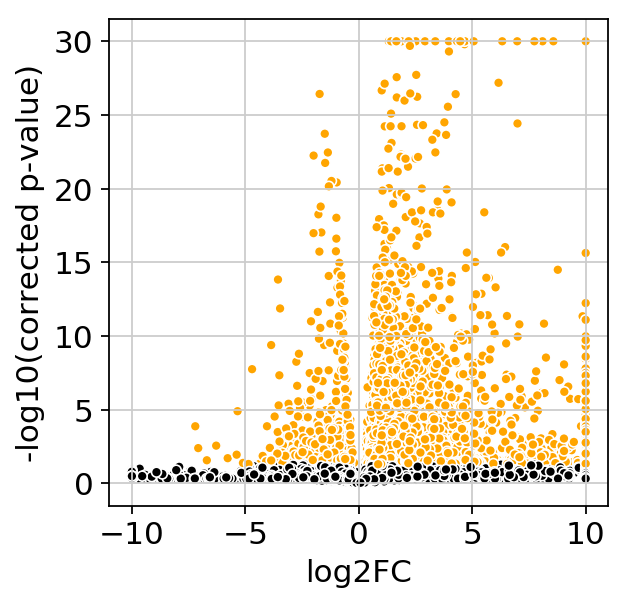

         gene           pval  ...  zero_mean  zero_variance
12649   Satb1  2.222631e-104  ...      False          False
14306    Tcf7   5.191109e-76  ...      False          False
11899   Ramp1   2.542583e-75  ...      False          False
4690     Dntt   1.466225e-71  ...      False          False
3123     Ccr9   1.247537e-69  ...      False          False
7061    H3f3a   5.852738e-68  ...      False          False
3221     Cd8a   2.355932e-62  ...      False          False
5122    Endou   6.980787e-57  ...      False          False
1874    Aqp11   1.245732e-54  ...      False          False
6217   Glcci1   6.105118e-53  ...      False          False
2022   Arpp21   1.568547e-52  ...      False          False
7303    Hmgb1   2.428388e-52  ...      False          False
8347     Ldhb   4.682786e-52  ...      False          False
8802   Marcks   2.149057e-51  ...      False          False
3222    Cd8b1   2.801745e-51  ...      False          False
13710    Sox4   1.695307e-49  ...      F

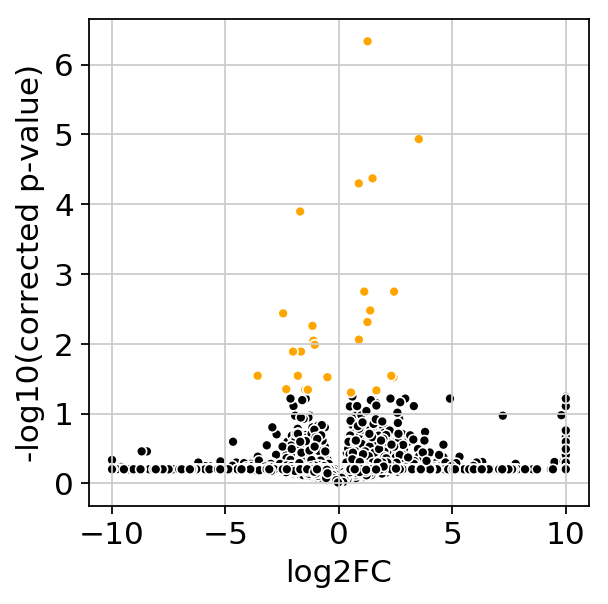

                gene          pval  ...  zero_mean  zero_variance
1003   A130040M12Rik  3.043657e-11  ...      False          False
7581          Igfbp4  1.532199e-09  ...      False          False
3121            Ccr7  8.379900e-09  ...      False          False
8100           Klf13  1.319974e-08  ...      False          False
2483            Bcl2  4.166850e-08  ...      False          False
10082           Npc2  7.200970e-07  ...      False          False
4339           Dapl1  8.198677e-07  ...      False          False
7533        Ifi27l2a  1.744054e-06  ...      False          False
1515           Ahnak  2.156048e-06  ...      False          False
4667          Dnajc8  3.196110e-06  ...      False          False
8844           Mbnl1  3.982216e-06  ...      False          False
9452          Ms4a6b  6.849758e-06  ...      False          False
6684            Gnas  7.681589e-06  ...      False          False
9984            Nkg7  9.469666e-06  ...      False          False
3082      

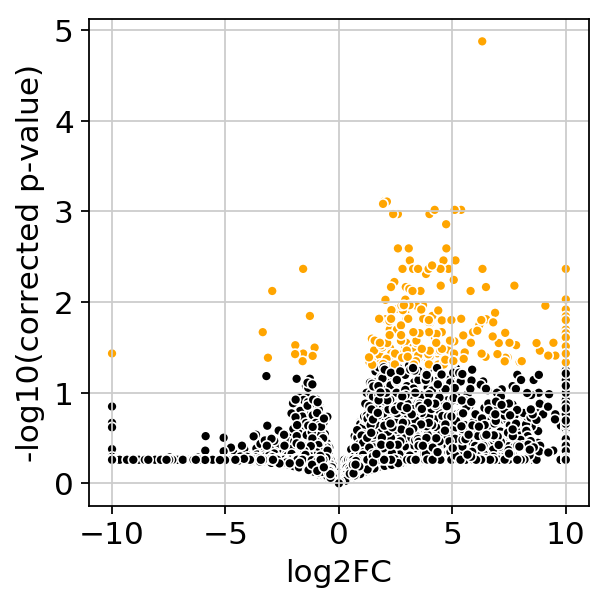

                gene          pval  ...  zero_mean  zero_variance
12780         Sec23b  8.836848e-10  ...      False          False
1925        Arhgap30  1.178595e-07  ...      False          False
1104        AI467606  1.550595e-07  ...      False          False
15091        Tsc22d4  2.191819e-07  ...      False          False
13862          Srprb  3.483266e-07  ...      False          False
15878          Yif1a  3.940999e-07  ...      False          False
10686          Pde6d  4.465830e-07  ...      False          False
5422         Fam134c  6.226869e-07  ...      False          False
5933          Fundc1  6.552435e-07  ...      False          False
9006             Mff  7.101575e-07  ...      False          False
804    4933433P14Rik  1.010978e-06  ...      False          False
9432          Mrps30  2.090733e-06  ...      False          False
15821           Xab2  2.374141e-06  ...      False          False
14951        Trappc1  2.376893e-06  ...      False          False
12303     

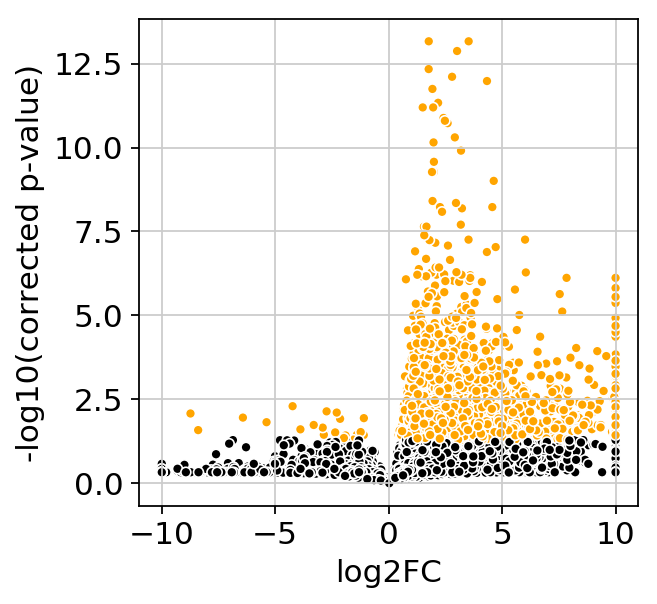

           gene          pval  ...  zero_mean  zero_variance
11575    Psmb10  6.783584e-18  ...      False          False
13032    Shisa5  9.192973e-18  ...      False          False
7538      Ifi47  2.682414e-17  ...      False          False
1938    Arhgdib  1.234907e-16  ...      False          False
13424     Slfn2  2.614439e-16  ...      False          False
1557       Akna  4.200980e-16  ...      False          False
11690   Ptprcap  8.421653e-16  ...      False          False
6882     Grcc10  2.489693e-15  ...      False          False
11583     Psmb8  4.082759e-15  ...      False          False
3189       Cd3d  4.276257e-15  ...      False          False
2298   B4galnt1  9.685921e-15  ...      False          False
14229  Tbc1d10c  1.278639e-14  ...      False          False
7622       Il16  1.633902e-14  ...      False          False
6183     Gimap9  4.666435e-14  ...      False          False
9449     Ms4a4b  7.062167e-14  ...      False          False
1104   AI467606  1.32367

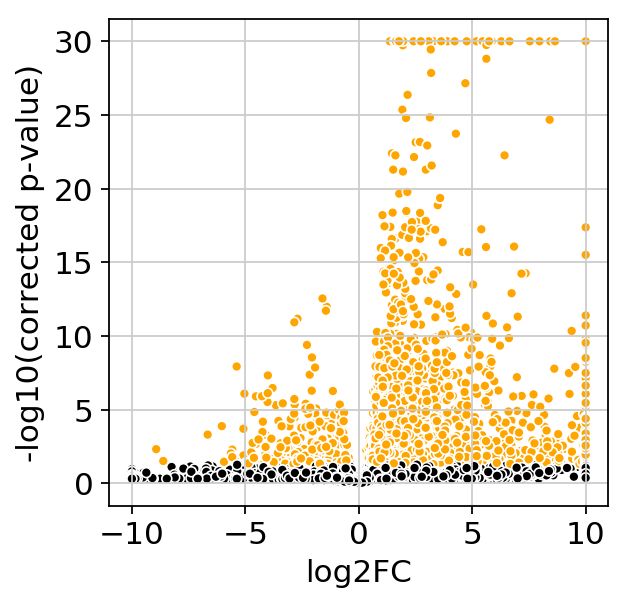

         gene           pval  ...  zero_mean  zero_variance
12649   Satb1  1.420246e-111  ...      False          False
4690     Dntt   2.089497e-71  ...      False          False
3123     Ccr9   1.726878e-70  ...      False          False
9089   Mir142   9.767869e-62  ...      False          False
11899   Ramp1   1.044274e-60  ...      False          False
3221     Cd8a   6.208181e-57  ...      False          False
5122    Endou   1.451591e-56  ...      False          False
14306    Tcf7   6.879604e-52  ...      False          False
2022   Arpp21   8.865587e-52  ...      False          False
3222    Cd8b1   3.917653e-51  ...      False          False
1804    Ap3s1   1.427351e-50  ...      False          False
8332      Lck   3.277540e-50  ...      False          False
8802   Marcks   3.280590e-50  ...      False          False
1874    Aqp11   3.433219e-50  ...      False          False
6217   Glcci1   1.541692e-49  ...      False          False
1231     Abi3   3.315486e-48  ...      F

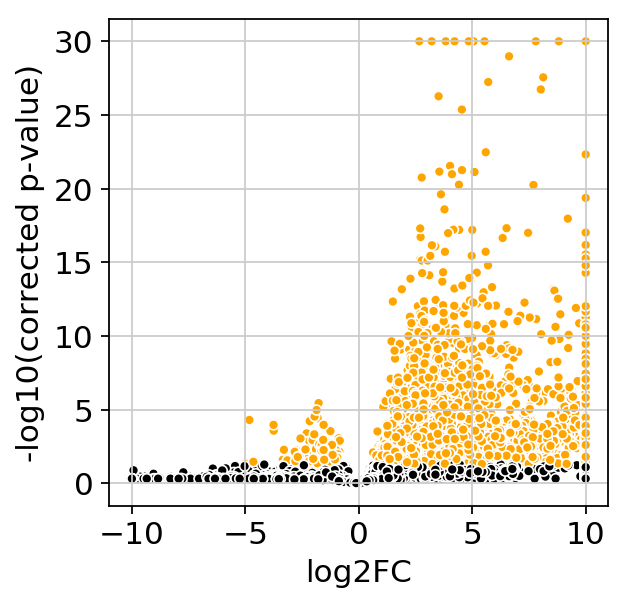

          gene          pval  ...  zero_mean  zero_variance
4690      Dntt  6.750959e-72  ...      False          False
3123      Ccr9  1.459192e-70  ...      False          False
3221      Cd8a  1.833373e-66  ...      False          False
6217    Glcci1  4.345805e-59  ...      False          False
5122     Endou  6.980787e-57  ...      False          False
1874     Aqp11  5.026707e-55  ...      False          False
2022    Arpp21  1.493181e-52  ...      False          False
8802    Marcks  2.560771e-52  ...      False          False
12649    Satb1  7.821456e-52  ...      False          False
11882     Rag1  9.310777e-47  ...      False          False
8635      Ly6d  1.690046e-46  ...      False          False
13710     Sox4  2.068124e-44  ...      False          False
15091  Tsc22d4  1.712773e-42  ...      False          False
3169     Cd24a  8.301018e-42  ...      False          False
3703      Cnn3  1.152224e-40  ...      False          False
11883     Rag2  1.317566e-40  ...      F

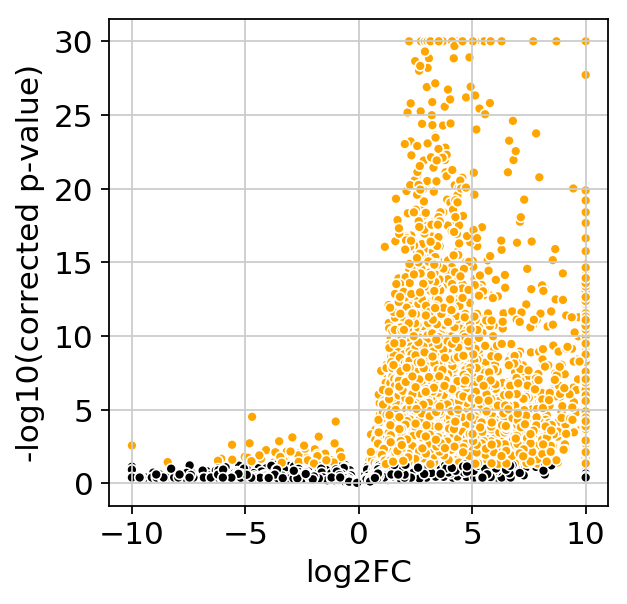

         gene          pval  ...  zero_mean  zero_variance
3123     Ccr9  1.485891e-76  ...      False          False
4690     Dntt  8.744067e-72  ...      False          False
12649   Satb1  8.758540e-59  ...      False          False
1231     Abi3  7.426977e-58  ...      False          False
5122    Endou  7.398304e-57  ...      False          False
1874    Aqp11  9.592604e-55  ...      False          False
8332      Lck  1.192139e-54  ...      False          False
3094    Ccnd3  6.222538e-54  ...      False          False
6217   Glcci1  9.249503e-54  ...      False          False
8802   Marcks  7.798307e-53  ...      False          False
2022   Arpp21  1.526934e-52  ...      False          False
3221     Cd8a  9.264474e-51  ...      False          False
4130     Cyb5  3.877415e-50  ...      False          False
16432   Znrf1  2.425865e-48  ...      False          False
14306    Tcf7  5.906615e-48  ...      False          False
11882    Rag1  9.446164e-47  ...      False          Fal

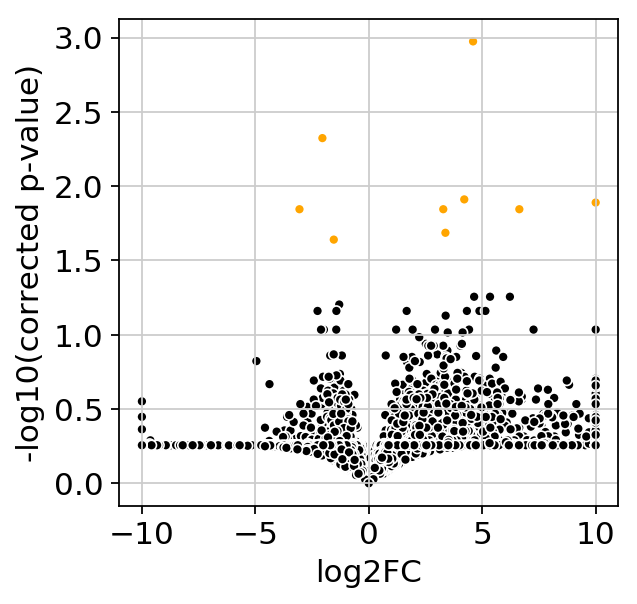

                gene          pval  ...  zero_mean  zero_variance
3142           Cd160  7.520669e-08  ...      False          False
2657            Btg1  6.731400e-07  ...      False          False
3562            Cish  2.610738e-06  ...      False          False
1582             Alb  3.655269e-06  ...      False          False
3539           Chsy1  5.771484e-06  ...      False          False
3121            Ccr7  6.506453e-06  ...      False          False
12874      Serpina3g  7.092863e-06  ...      False          False
895    6330512M04Rik  1.167922e-05  ...      False          False
15090        Tsc22d3  1.460696e-05  ...      False          False
8187           Klre1  4.180203e-05  ...      False          False
14278          Tbx21  4.669859e-05  ...      False          False
13941          Stap1  4.720705e-05  ...      False          False
6445          Gm1821  5.769316e-05  ...      False          False
12620          Samd3  7.519022e-05  ...      False          False
11250     

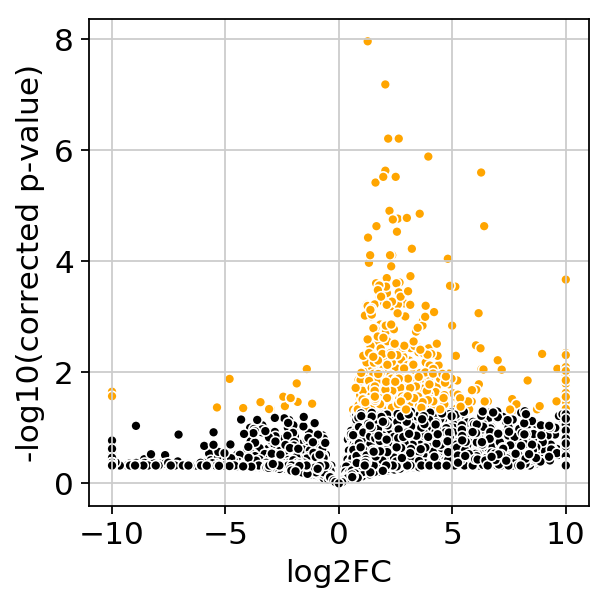

           gene          pval  ...  zero_mean  zero_variance
12244     Rn45s  7.780818e-13  ...      False          False
11690   Ptprcap  9.318896e-12  ...      False          False
6177     Gimap3  1.703130e-10  ...      False          False
2483       Bcl2  1.763720e-10  ...      False          False
11575    Psmb10  4.646039e-10  ...      False          False
9449     Ms4a4b  1.001744e-09  ...      False          False
4119      Cxcr3  1.259911e-09  ...      False          False
2298   B4galnt1  1.811567e-09  ...      False          False
11583     Psmb8  1.939456e-09  ...      False          False
2866      Capzb  2.730993e-09  ...      False          False
1140   AW112010  9.711623e-09  ...      False          False
3082       Ccl5  1.195183e-08  ...      False          False
7538      Ifi47  1.540728e-08  ...      False          False
6178     Gimap4  1.710325e-08  ...      False          False
9984       Nkg7  1.896502e-08  ...      False          False
3142      Cd160  2.73526

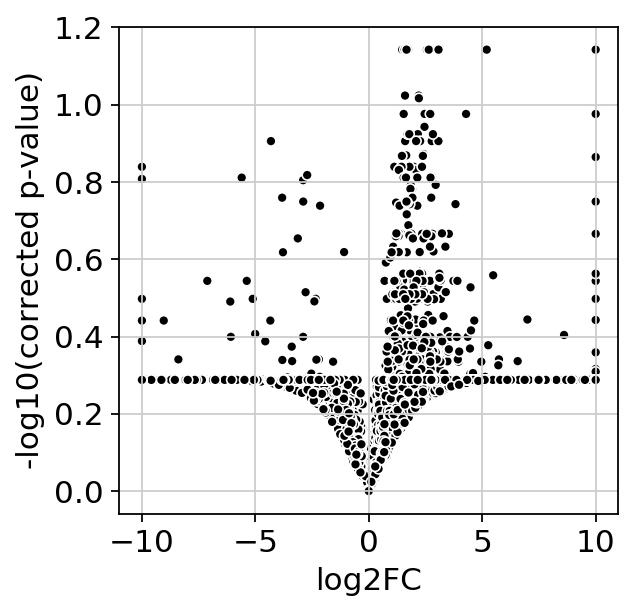

           gene      pval      qval  ...         mean  zero_mean  zero_variance
6100        Gcg  0.000006  0.072008  ...     1.229885      False          False
1938    Arhgdib  0.000013  0.072008  ...  1571.137969      False          False
15090   Tsc22d3  0.000017  0.072008  ...   575.356327      False          False
12808    Selplg  0.000034  0.072008  ...   866.482790      False          False
8100      Klf13  0.000037  0.072008  ...   780.471277      False          False
2657       Btg1  0.000040  0.072008  ...  1534.494270      False          False
13424     Slfn2  0.000049  0.072008  ...   262.114933      False          False
3836     Coro1a  0.000049  0.072008  ...  1796.655218      False          False
7720       Ins2  0.000051  0.072008  ...     1.275862      False          False
8414      Limd2  0.000081  0.094680  ...   826.413785      False          False
1329       Actb  0.000082  0.094680  ...  9623.378996      False          False
9452     Ms4a6b  0.000091  0.096175  ...

In [29]:
test_by = 'tissue'
test_groups = ['Spleen', 'Thymus', 'Marrow', 'Lung', 'Limb_Muscle']
pairwiseDE(test_by, test_groups)

# Dimensionality Reduction, Data Correction, Clustering and Cell Annotation

Identify the highly-variable genes in our dataset, genes with expression that is very different between cells. These our the target genes to look at as they are different between cells and can be used to identify different cell types.

The function also adds new columns to adata.var which indicates for each gene whether it is highly variable and what its mean expression, dispersion and normalized dispersion are.

In [30]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=10, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Create two scatter plots showing dispersion of genes (normalized and non normalized) versus mean expression of genes where the highly variable genes are separately labeled. 

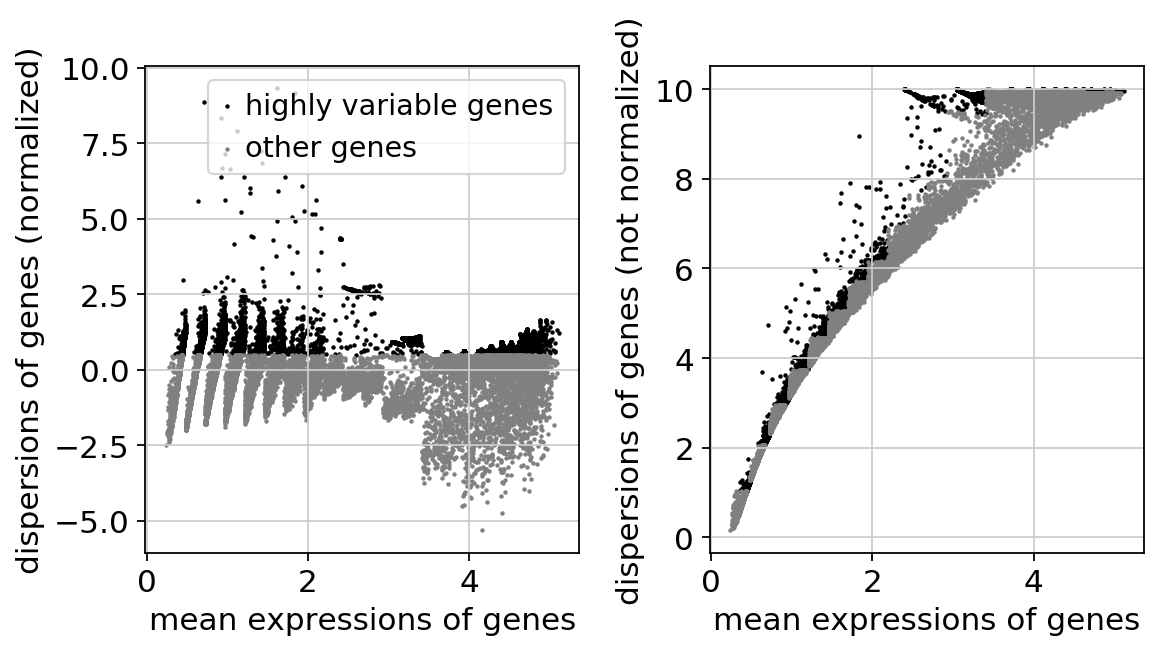

In [31]:
sc.pl.highly_variable_genes(adata)

## Principal Component Analysis

Principal Component Analysis (PCA) reduces the dimensionality of the data by creating new variables(Principal components) that are linear combinations of the orginal variables which contain most of the variance in our dataset.

In [32]:
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01)


Scatter plot showing our first two principal components.

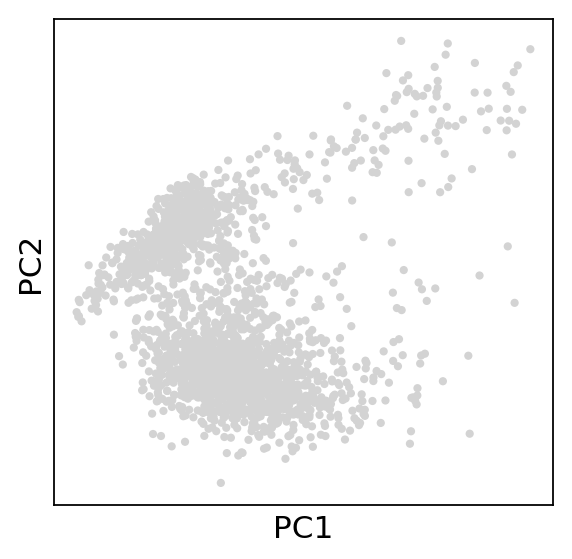

In [33]:
sc.pl.pca(adata)

Here the Principal Components are ranked according to the variance they represent in the data set. Each further principal component has a decreased explanation of the varaince it accounts for and this ranking gives information about how many PCs that should be considered in order to compute the neighborhood relations of cells in methods such as louvain clustering or tSNE visualization.

The number of PCs used is usually chosen when you have obtained enough PCs to explain the majority of the variance in your data and each additional PC does not contribute much.

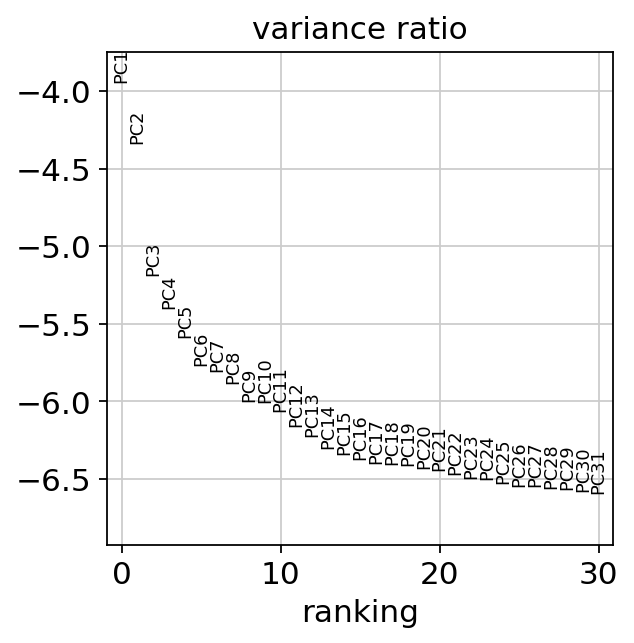

In [34]:
sc.pl.pca_variance_ratio(adata, log=True)

Compute the neighborhood graph of cells using the PCA representation.

In [35]:
sc.pp.neighbors(adata, n_neighbors=10)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [36]:
sc.tl.umap(adata)
sc.tl.tsne(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:21)


## Data Correction

Check for batch effects of mouse_id, mouse_sex and plate by t-SNE projection.

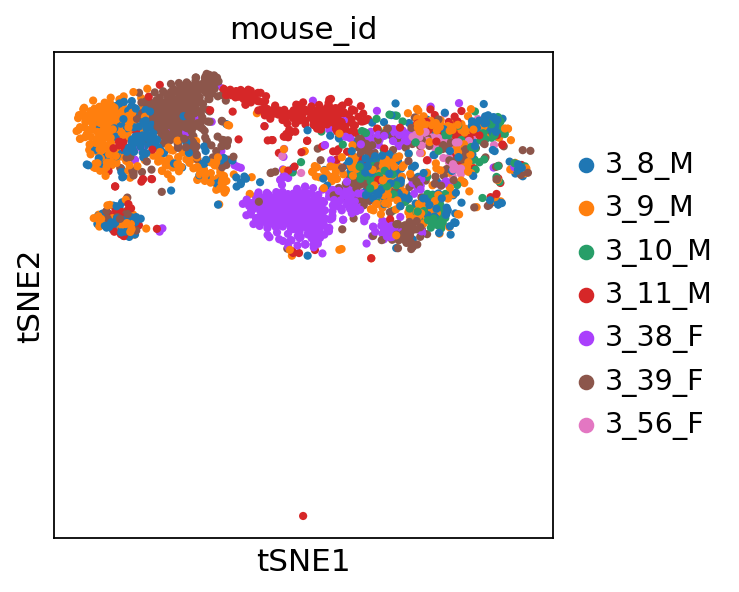

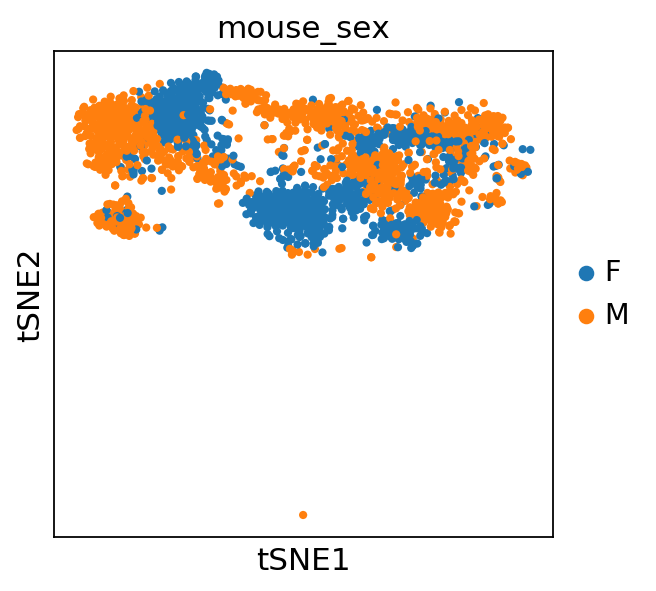

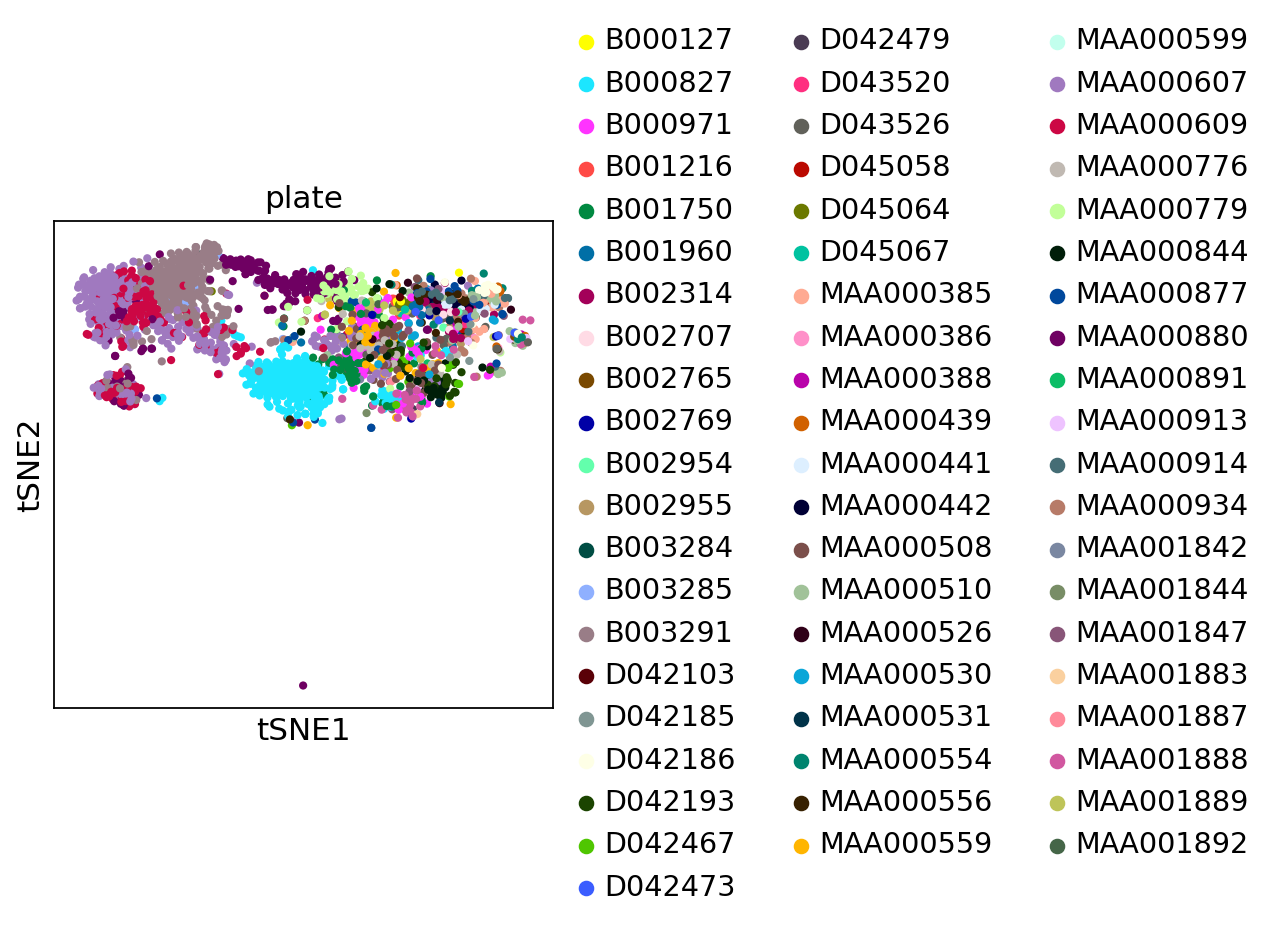

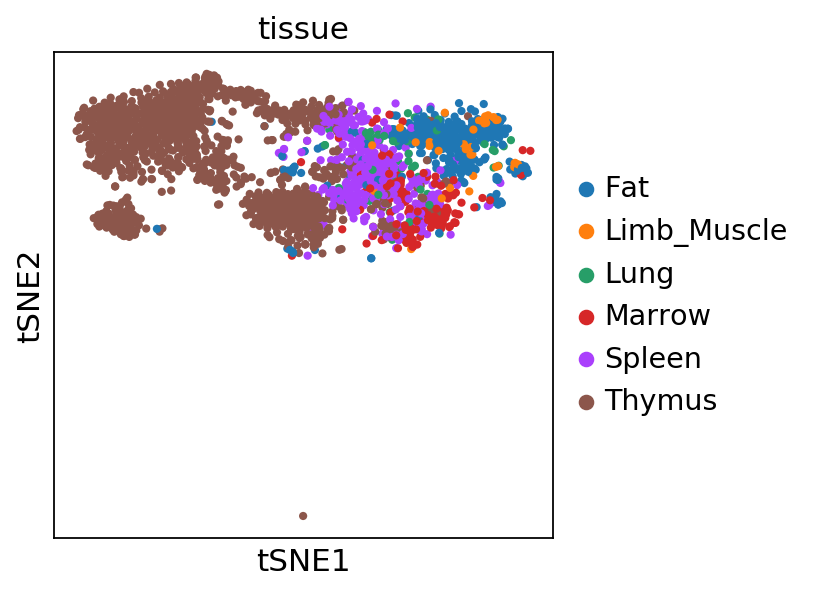

In [37]:
sc.pl.tsne(adata,color='mouse_id')
sc.pl.tsne(adata,color='mouse_sex')
sc.pl.tsne(adata,color='plate')
sc.pl.tsne(adata,color='tissue')

Batch correction using bbknn.

In [39]:
bk.bbknn(adata, batch_key='mouse_id')
bk.bbknn(adata, batch_key='mouse_sex')
#bk.bbknn(adata, batch_key='plate')
bk.bbknn(adata, batch_key='tissue')

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:02)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)
computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:00)


Post batch correction projection of cells using t-SNE.

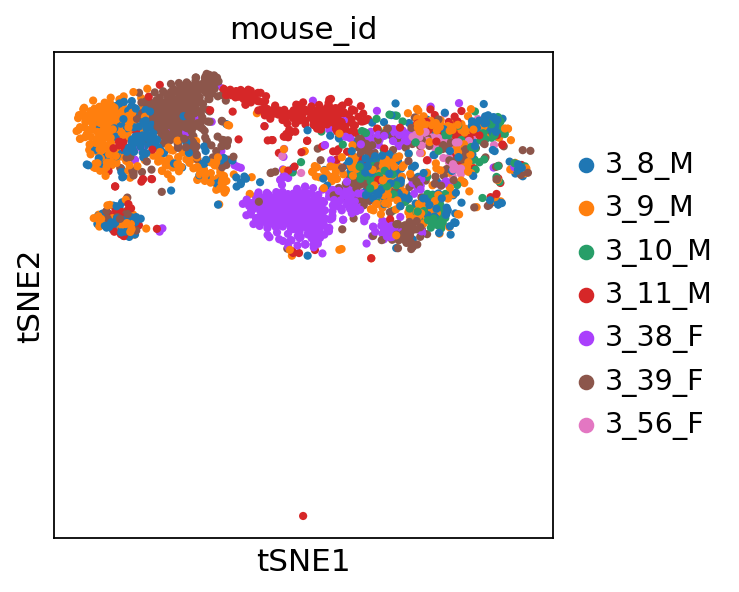

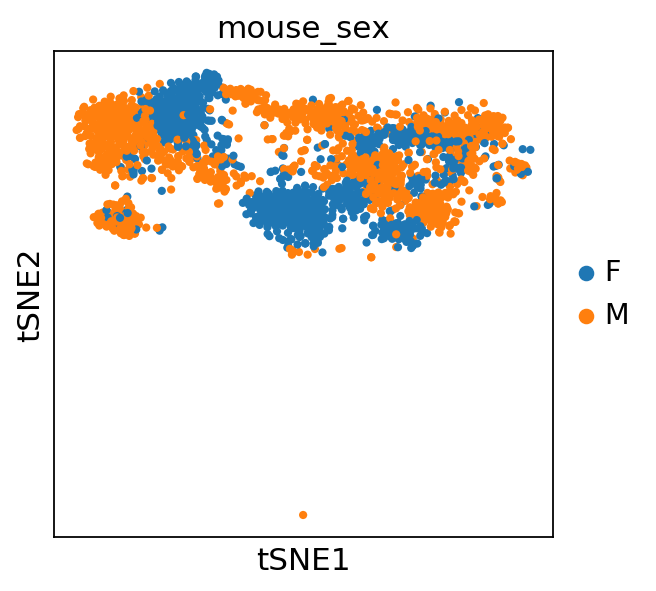

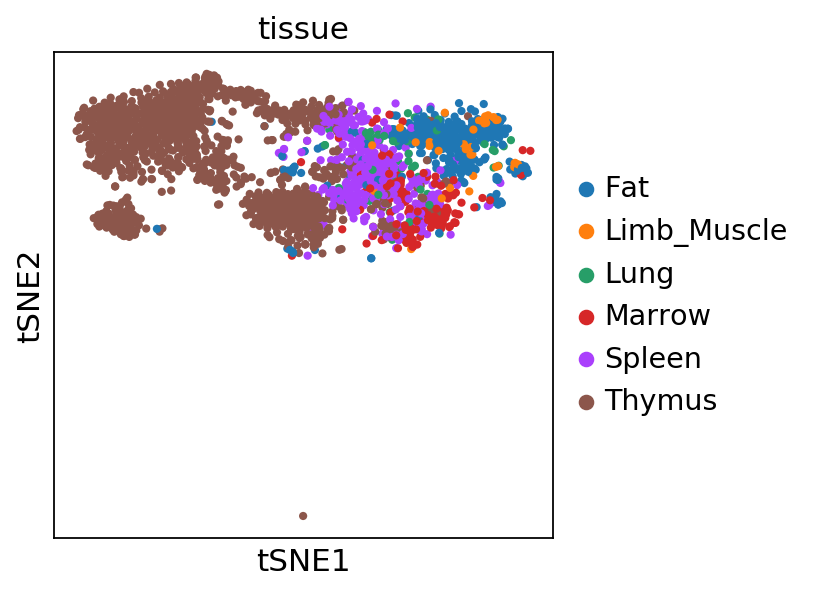

In [40]:
sc.pl.tsne(adata,color='mouse_id')
sc.pl.tsne(adata,color='mouse_sex')
sc.pl.tsne(adata,color='tissue')

## Cell Clustering

Clustering using Louvain algorithm.

In [41]:
sc.tl.louvain(adata,resolution=1)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


Projection of Louvain clustering in UMAP and t-SNE labeled by Louvain clusters and by reference annotation.

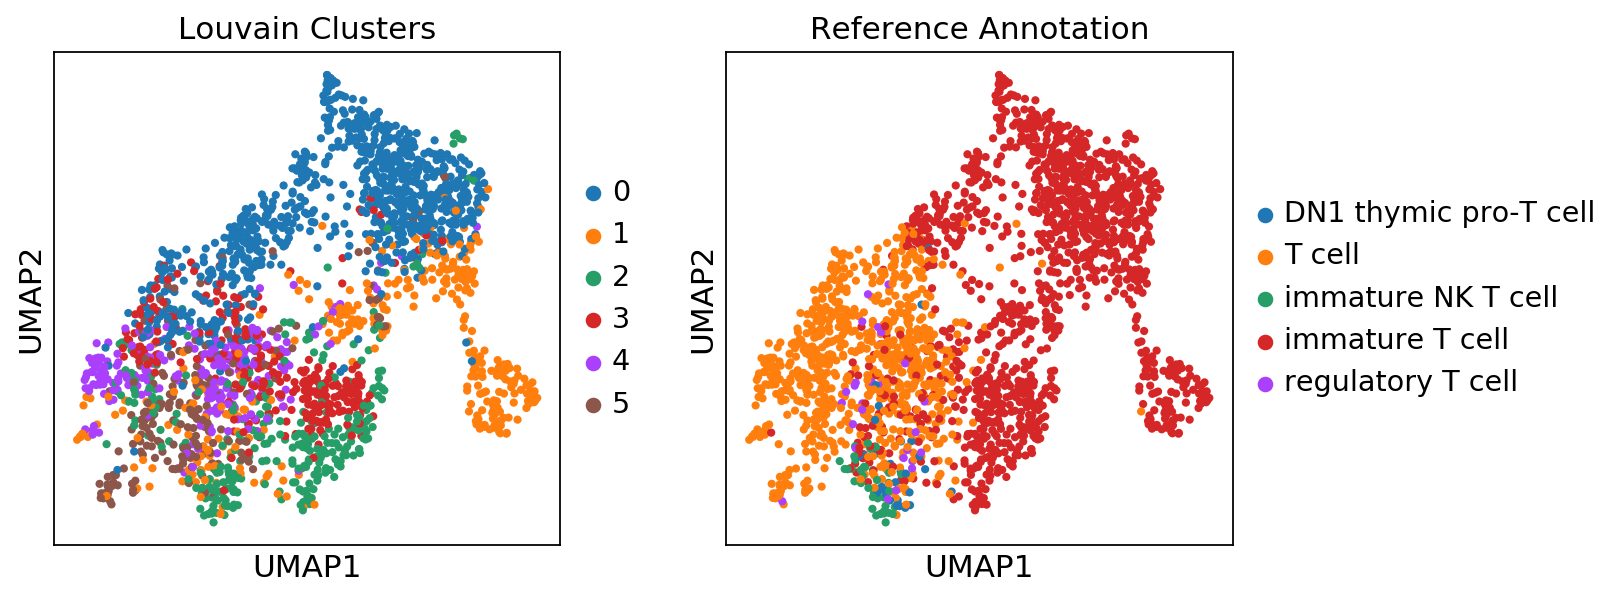

In [42]:
sc.pl.umap(adata, color=['louvain','ref_annotation'], title=['Louvain Clusters', 'Reference Annotation'])

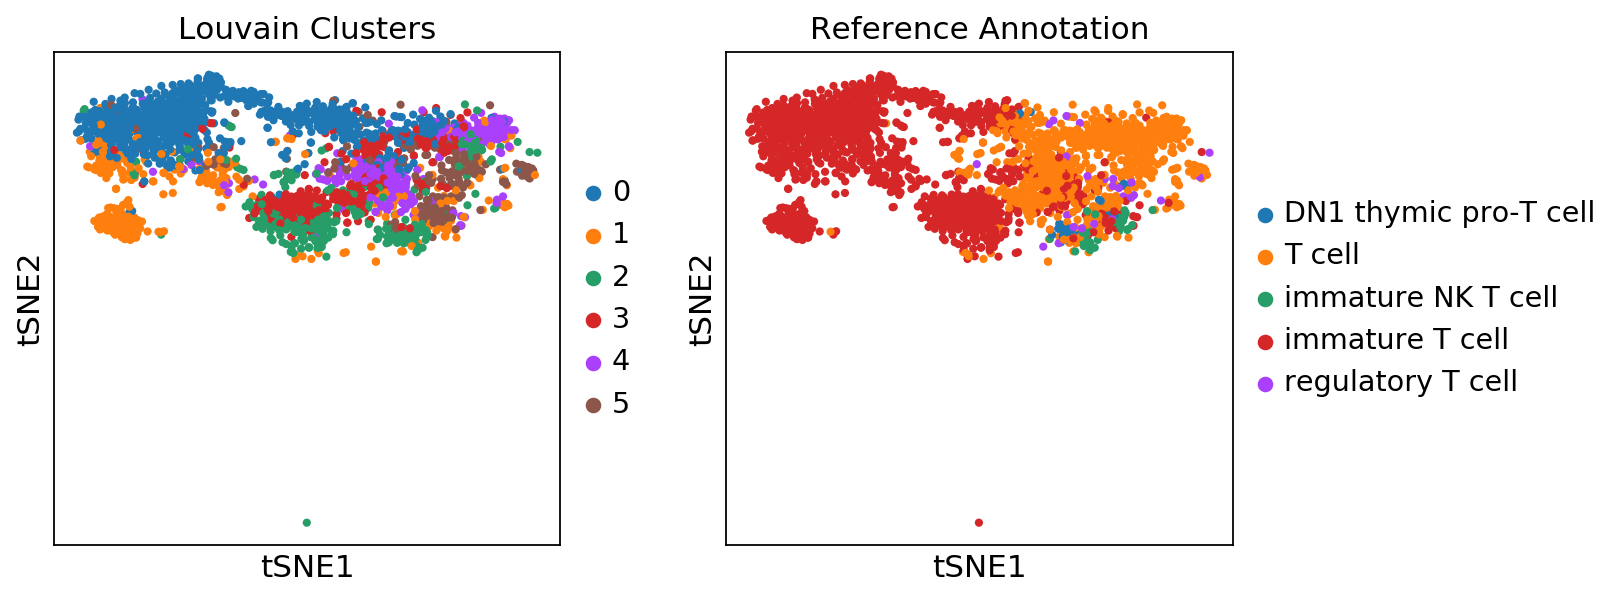

In [44]:
sc.pl.tsne(adata, color=['louvain','ref_annotation'], title=['Louvain Clusters', 'Reference Annotation'])

Compute a ranking for the highly expressed genes in each cluster using Wilcoxon rank-sum.

In [45]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon', use_raw=False)

ranking genes


/usr/local/lib/python3.6/dist-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [0]:
adata.write(results_file)

# Trajectory inference

## PAGA

PAGA trajectory inference by reference annotation.

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


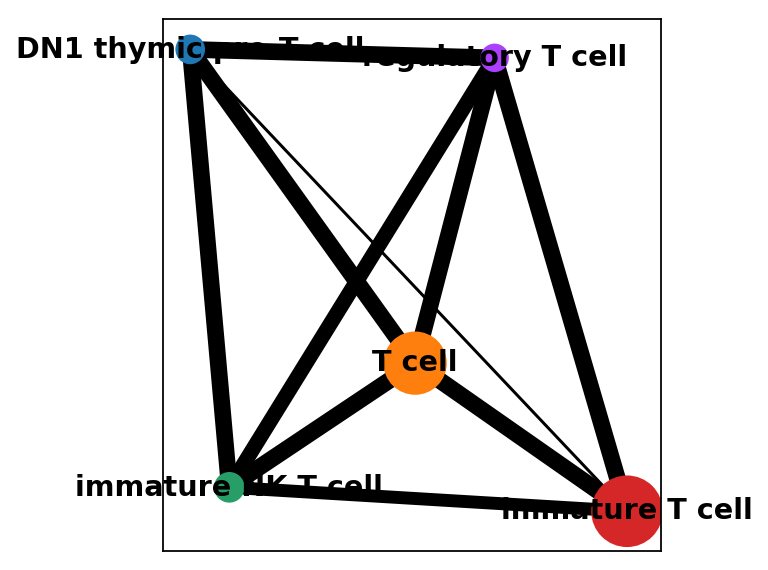

In [47]:
sc.tl.paga(adata, groups='ref_annotation')
sc.pl.paga(adata, threshold=0.1, color='ref_annotation')

In [0]:
adata.write(results_file)

In [0]:
adata_ti = adata.copy()

UMAP projection of PAGA calculated pseudo-time of T cells labeled by reference annotation.

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)


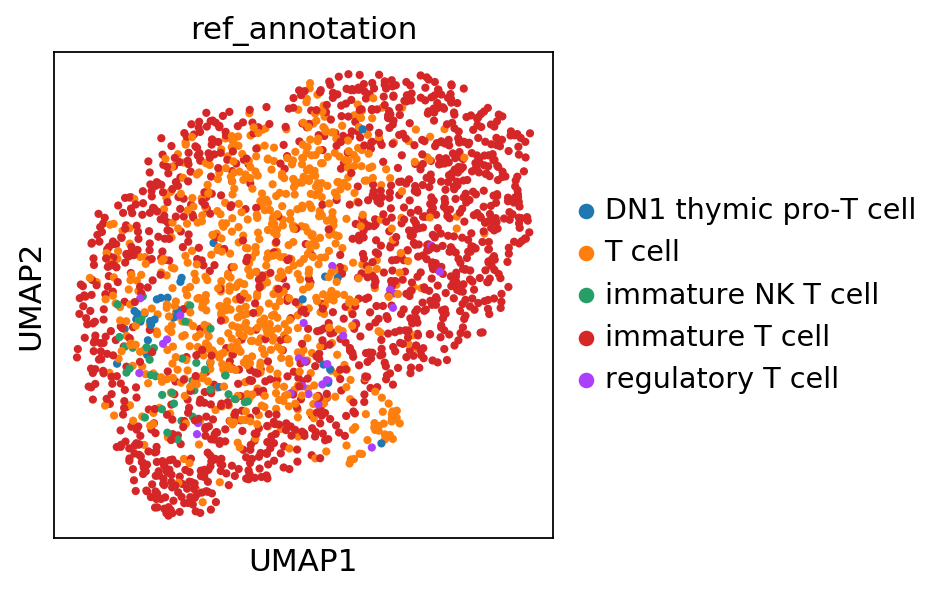

In [50]:
sc.tl.umap(adata_ti, init_pos=sc.tl._utils.get_init_pos_from_paga(adata))
sc.pl.umap(adata_ti, color='ref_annotation')

## Slingshot

Calculate the pseudo-time of the cell clusters (by reference annotation) using Slingshot. We stated two conditions, one with the starting cell stage and one with both starting and ending cell stage. For each of the conditions we use two dimensionality reduction methods, UMAP and PCA. 

[1] "1:"


R[write to console]: Using diagonal covariance matrix

R[write to console]: Using full covariance matrix



[1] "adata_start_pca"
class: SlingshotDataSet 

 Samples Dimensions
    2198         50

lineages: 3 
Lineage1: DN1 thymic pro-T cell  T cell  immature T cell  
Lineage2: DN1 thymic pro-T cell  T cell  regulatory T cell  
Lineage3: DN1 thymic pro-T cell  immature NK T cell  

curves: 3 
Curve1: Length: 78.623	Samples: 2057.13
Curve2: Length: 153.82	Samples: 1058.95
Curve3: Length: 87.421	Samples: 681.87
[1] "adata_start_umap"
class: SlingshotDataSet 

 Samples Dimensions
    2198          2

lineages: 2 
Lineage1: DN1 thymic pro-T cell  regulatory T cell  T cell  immature T cell  
Lineage2: DN1 thymic pro-T cell  immature NK T cell  

curves: 2 
Curve1: Length: 22.309	Samples: 2061.85
Curve2: Length: 8.5386	Samples: 689.94
[1] ""
[1] "2:"


R[write to console]: Using diagonal covariance matrix

R[write to console]: Using full covariance matrix



[1] "adata_startend_pca"
class: SlingshotDataSet 

 Samples Dimensions
    2198         50

lineages: 2 
Lineage1: DN1 thymic pro-T cell  regulatory T cell  immature T cell  T cell  
Lineage2: DN1 thymic pro-T cell  immature NK T cell  

curves: 2 
Curve1: Length: 211.32	Samples: 2143.69
Curve2: Length: 81.221	Samples: 1314.57
[1] "adata_startend_umap"
class: SlingshotDataSet 

 Samples Dimensions
    2198          2

lineages: 3 
Lineage1: DN1 thymic pro-T cell  regulatory T cell  immature T cell  
Lineage2: DN1 thymic pro-T cell  regulatory T cell  T cell  
Lineage3: DN1 thymic pro-T cell  immature NK T cell  

curves: 3 
Curve1: Length: 18.212	Samples: 1384.03
Curve2: Length: 14.31	Samples: 1023.81
Curve3: Length: 8.1182	Samples: 670.26


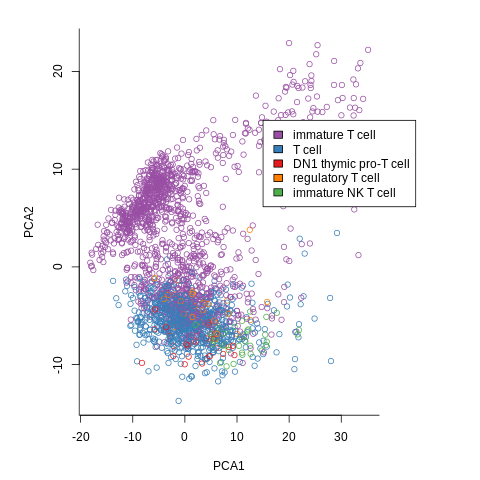

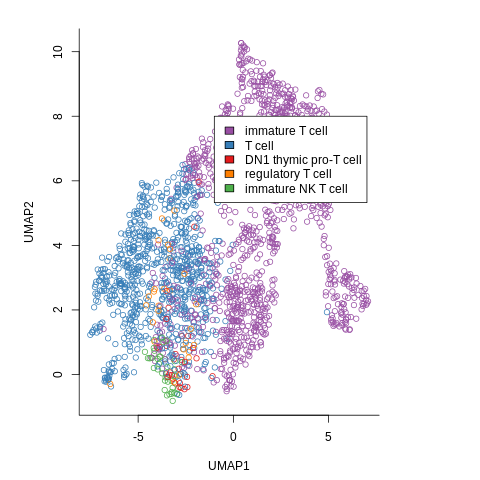

In [51]:
%%R -i adata

#Plot 1
colour_map = brewer.pal(9,'Set1')
par(xpd=TRUE)
par(mar=c(4.5,5.5,2,7))
plot(reducedDims(adata)$PCA[,1], reducedDims(adata)$PCA[,2], col=colour_map[colData(adata)$ref_annotation], bty='L', xlab='PCA1', ylab='PCA2')
legend(x=15, y=15, legend=unique(colData(adata)$ref_annotation), fill=colour_map[as.integer(unique(colData(adata)$ref_annotation))])
plot(reducedDims(adata)$UMAP[,1], reducedDims(adata)$UMAP[,2], col=colour_map[colData(adata)$ref_annotation], bty='L', xlab='UMAP1', ylab='UMAP2')
legend(x=-1, y=8, legend=unique(colData(adata)$ref_annotation), fill=colour_map[as.integer(unique(colData(adata)$ref_annotation))])

print("1:")
adata_start_pca <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'PCA', start.clus='DN1 thymic pro-T cell')
adata_start_umap <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'UMAP', start.clus='DN1 thymic pro-T cell')
print("adata_start_pca")
print(SlingshotDataSet(adata_start_pca))
print("adata_start_umap")
print(SlingshotDataSet(adata_start_umap))

print("")
print("2:")
adata_startend_pca <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'PCA', start.clus='DN1 thymic pro-T cell', end.clus='T cell')
adata_startend_umap <- slingshot(adata, clusterLabels = 'ref_annotation', reducedDim = 'UMAP', start.clus='DN1 thymic pro-T cell', end.clus='T cell')
print("adata_startend_pca")
print(SlingshotDataSet(adata_startend_pca))
print("adata_startend_umap")
print(SlingshotDataSet(adata_startend_umap))

Visualization of the best lineages by PCA and UMAP projection.

[1] "Lineage1_PCA"
[1] "Lineage1_UMAP"


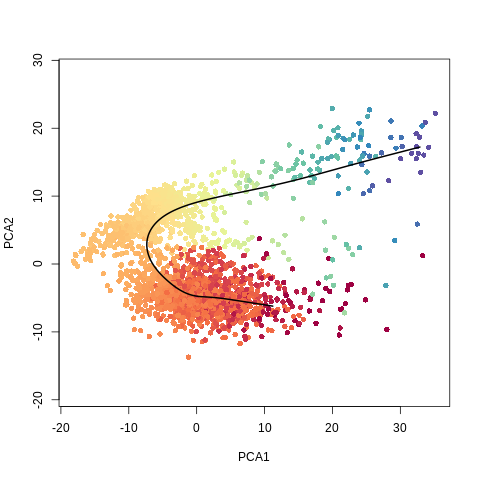

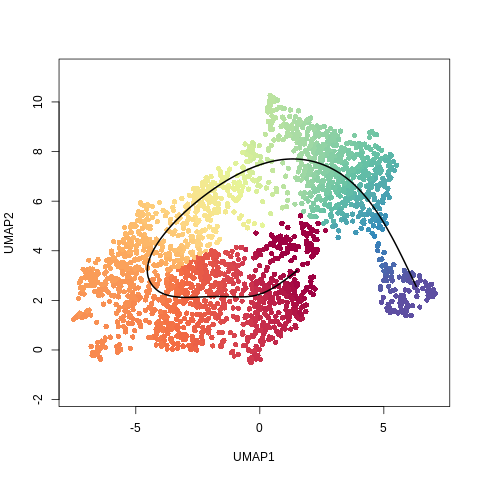

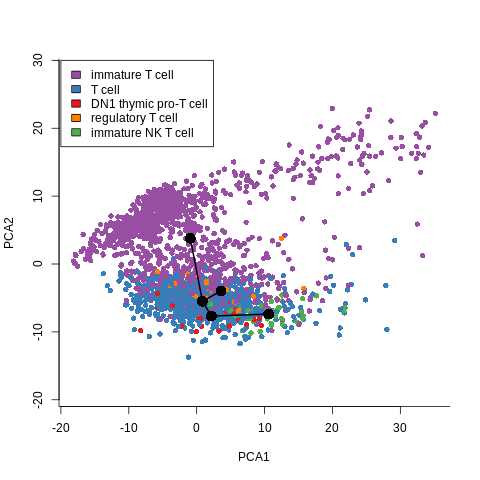

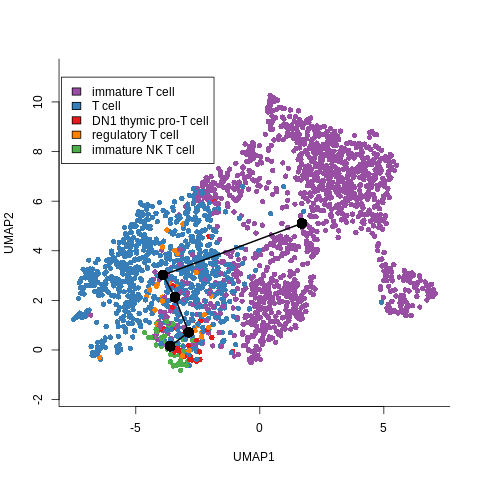

In [52]:
%%R
#Visualize the slingshot pseudo-time for adata_start
#Plot of the best lineage
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
print("Lineage1_PCA")
plot(reducedDims(adata_start_pca)$PCA[,c(1,2)], col = colors[cut(adata_start_pca$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PCA1', ylab='PCA2')
lines(slingCurves(adata_start_pca)$curve1, lwd=2)
print("Lineage1_UMAP")
plot(reducedDims(adata_start_umap)$UMAP[,c(1,2)], col = colors[cut(adata_start_umap$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(adata_start_umap)$curve1, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_start_pca)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='PCA1', ylab='PCA2')
lines(SlingshotDataSet(adata_start_pca), lwd=2, type='lineages')
legend(x=-20, y=30, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])

plot(reducedDims(adata_start_umap)$UMAP[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='UMAP1', ylab='UMAP2')
lines(SlingshotDataSet(adata_start_umap), lwd=2, type='lineages')
legend(x=-8, y=11, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])

[1] "Lineage1_PCA"
[1] "Lineage1_UMAP"


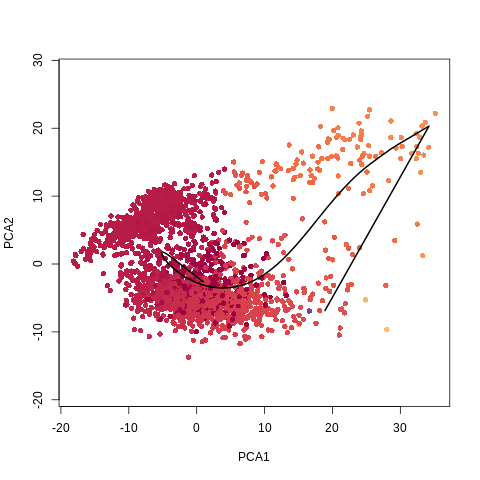

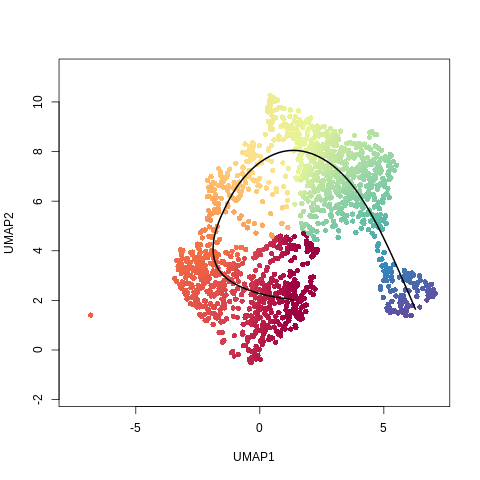

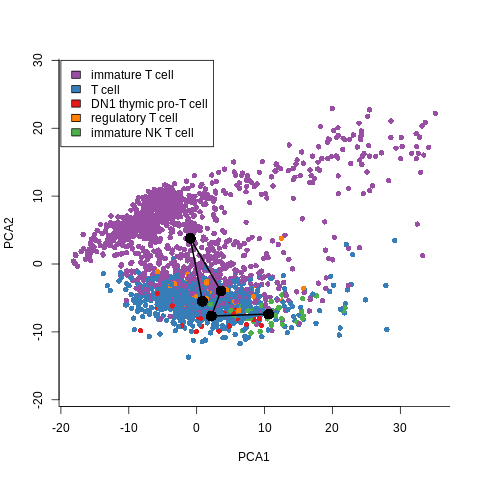

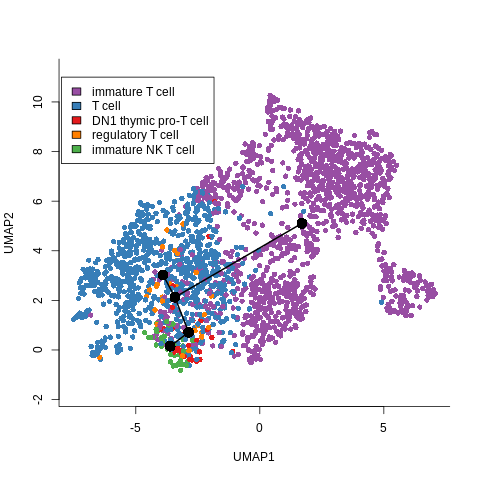

In [53]:
%%R
#Visualize Slingshot pseudo-time for adata_start_end
#Plot of the best lineage 
colors <- colorRampPalette(brewer.pal(11,'Spectral')[-6])(100)
print("Lineage1_PCA")
plot(reducedDims(adata_startend_pca)$PCA[,c(1,2)], col = colors[cut(adata_startend_pca$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='PCA1', ylab='PCA2')
lines(slingCurves(adata_startend_pca)$curve1, lwd=2)
print("Lineage1_UMAP")
plot(reducedDims(adata_startend_umap)$UMAP[,c(1,2)], col = colors[cut(adata_startend_umap$slingPseudotime_1,breaks=100)], pch=16, asp = 1, xlab='UMAP1', ylab='UMAP2')
lines(slingCurves(adata_startend_umap)$curve1, lwd=2)

#Plot of lineages with clusters visualized
par(xpd=TRUE)
plot(reducedDims(adata_startend_pca)$PCA[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='PCA1', ylab='PCA2')
lines(SlingshotDataSet(adata_startend_pca), lwd=2, type='lineages')
legend(x=-20, y=30, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])

plot(reducedDims(adata_startend_umap)$UMAP[,c(1,2)], col = brewer.pal(11,'Set1')[adata$ref_annotation], pch=16, asp = 1, bty='L', xlab='UMAP1', ylab='UMAP2')
lines(SlingshotDataSet(adata_startend_umap), lwd=2, type='lineages')
legend(x=-8, y=11, legend=unique(colData(adata)$ref_annotation), fill=brewer.pal(11,'Set1')[as.integer(unique(colData(adata)$ref_annotation))])


# Conversion to a Loom file

In [57]:
def dfToNamedMatrix(df):
    arr_ip = [tuple(i) for i in df.as_matrix()]
    dtyp = np.dtype(list(zip(df.dtypes.index, df.dtypes)))
    arr = np.array(arr_ip, dtype=dtyp)
    return arr

ClusterMarkers_0 = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0_avg_logFC = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0_pval = pd.DataFrame(
    index=adata.raw.var.index,
    columns=[str(x) for x in range(max(set([int(x) for x in adata.obs['louvain']])) + 1)]
)

ClusterMarkers_0.fillna(0, inplace=True)
ClusterMarkers_0_avg_logFC.fillna(0, inplace=True)
ClusterMarkers_0_pval.fillna(0, inplace=True)

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    i = str(i)
    tot_genes = len(adata.uns['rank_genes_groups']['pvals_adj'][i])
    sigGenes = adata.uns['rank_genes_groups']['pvals_adj'][i] < 0.05
    deGenes = np.logical_and(np.logical_or(adata.uns['rank_genes_groups']['logfoldchanges'][i] >= 1.5,
                                           adata.uns['rank_genes_groups']['logfoldchanges'][i] <= -1.5),
                             np.isfinite(adata.uns['rank_genes_groups']['logfoldchanges'][i]))
    sigAndDE = np.logical_and(sigGenes, deGenes)
    names = adata.uns['rank_genes_groups']['names'][i][sigAndDE]
    ClusterMarkers_0.loc[names, i] = 1
    ClusterMarkers_0_avg_logFC.loc[names, i] = np.around(adata.uns['rank_genes_groups']['logfoldchanges'][i][sigAndDE],
                                                         decimals=6)
    ClusterMarkers_0_pval.loc[names, i] = np.around(adata.uns['rank_genes_groups']['pvals_adj'][i][sigAndDE],
                                                    decimals=6)

metaJson = {}
metaJson["metrics"] = []
metaJson["annotations"] = []

main_dr = pd.DataFrame(adata.obsm['X_umap'], columns=['_X', '_Y'])

metaJson['embeddings'] = [
    {
        "id": -1,
        "name": "HVG UMAP"
    }
]

Embeddings_X = pd.DataFrame()
Embeddings_Y = pd.DataFrame()

embeddings_id = 1

if 'X_tsne' in adata.obsm.keys():
    Embeddings_X[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_tsne'])[0]
    Embeddings_Y[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_tsne'])[1]
    metaJson['embeddings'].append(
        {
            "id": embeddings_id,
            "name": "HVG t-SNE"
        }
    )
    embeddings_id += 1

Embeddings_X[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_pca'])[0]
Embeddings_Y[str(embeddings_id)] = pd.DataFrame(adata.obsm['X_pca'])[1]
metaJson['embeddings'].append(
    {
        "id": embeddings_id,
        "name": "HVG PC1/PC2"
    }
)

metaJson["clusterings"] = [
    {
        "id": 0,
        "group": "Louvain",
        "name": "Louvain default resolution",
        "clusters": [],
        "clusterMarkerMetrics": [
            {
                "accessor": "avg_logFC",
                "name": "Avg. logFC",
                "description": "Average log fold change from Wilcox test"
            }, {
                "accessor": "pval",
                "name": "Adjusted P-Value",
                "description": "Adjusted P-Value from Wilcox test"
            }
        ]
    }
]

for i in range(max(set([int(x) for x in adata.obs['louvain']])) + 1):
    clustDict = {}
    clustDict['id'] = i
    clustDict['description'] = f'Unannotated Cluster {i}'
    metaJson['clusterings'][0]['clusters'].append(clustDict)

clusterings = pd.DataFrame()

clusterings["0"] = adata.obs['louvain'].values.astype(np.int64)

col_attrs = {
    "CellID": np.array(adata.obs.index),
    "Embedding": dfToNamedMatrix(main_dr),
    "Embeddings_X": dfToNamedMatrix(Embeddings_X),
    "Embeddings_Y": dfToNamedMatrix(Embeddings_Y),
    "Clusterings": dfToNamedMatrix(clusterings),
    "ClusterID": np.array(adata.obs['louvain'].values)
}

for col in adata.obs.keys():
    if type(adata.obs[col].dtype) == pd.core.dtypes.dtypes.CategoricalDtype:
        metaJson["annotations"].append(
            {
                "name": col,
                "values": list(set(adata.obs[col].values))
            }
        )
    else:
        metaJson["metrics"].append(
            {
                "name": col
            }
        )
    col_attrs[col] = np.array(adata.obs[col].values)

row_attrs = {
    "Gene": np.array(adata.raw.var.index),
    "ClusterMarkers_0": dfToNamedMatrix(ClusterMarkers_0),
    "ClusterMarkers_0_avg_logFC": dfToNamedMatrix(ClusterMarkers_0_avg_logFC),
    "ClusterMarkers_0_pval": dfToNamedMatrix(ClusterMarkers_0_pval)
}

attrs = {"MetaData": json.dumps(metaJson)}

attrs['MetaData'] = base64.b64encode(zlib.compress(json.dumps(metaJson).encode('ascii'))).decode('ascii')

lp.create(
    filename="/content/drive/My Drive/IntegratedProject/Data/write/LoomFiles/Fat.loom",
    layers=(adata.raw.X).T,
    row_attrs=row_attrs,
    col_attrs=col_attrs,
    file_attrs=attrs
)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
